# Programa de Pós-Graduação em Computação Aplicada (UnB)
## Disciplina: ANÁLISE ESTATÍSTICA DE DADOS E INFORMAÇÕES - Turma 01 - 2023/1
## Professor: João Gabriel de Moraes Souza
## Aluno: Francisco Gonçalves de Araújo Filho
## Matrícula: 231109675
### Tarefa 5

A Tarefa irá se basear na aplicação prática de um problema de Ciência de Dados em Machine Learning. Esses problemas são originados de dados reais aplicados em problemas de Negócio. A Tarefa do 5 irá abordar a aplicação do problema Retenção de Clientes de Unidades Bancárias. Esse problema trata-se do objetivo de encontrar um modelo que seja capaz de prever se os indivíduos se mantiveram ou não clientes dos bancos. Com esses dados a Tarefa 5 pede:

### Questão a) Realize a previsão por um modelo de Regressão Logística.

### Preparação dos Dados

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

_debug = False

In [3]:
# Leitura dos dados em um Data frame
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')
df.shape

(10000, 14)

In [4]:
# Vefifica a lista de colunas e valores
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Retirando colunas sem necessidade

In [5]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [6]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Análise dos dados:
Com base no exposto acima, algumas questões não tem respostas:
- Os dados parecem ser uma fotografia em um determinado momento no tempo, por exemplo, o saldo é para uma determinada data, o que gera dúvidas:
    - Qual é a data e qual é a relevância dessa data?
    - Seria possível obter saldos ao longo de um período de tempo em vez de uma única data?
- Existem clientes que saíram, mas ainda possuem saldo em suas contas! O que isso poderia significar? Eles poderiam ter saído de um produto, mas não do banco?
- O que significa ser um membro ativo e existem diferentes graus disso? Seria melhor fornecer a contagem de transações em termos de créditos e débitos na conta?
- Uma análise detalhada dos produtos adquiridos por um cliente poderia fornecer mais informações além da simples contagem de produtos.

In [7]:
# Checando os tipos das variáveis
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

### Análise Exploratória de Dados (Exploratory Data Analysis, EDA)
O principal interesse no problema é compreender como as variáveis condicionais fornecidas se relacionam com o status da variável de interesse *'Exited'*, relativa a retenção ou abandono de clientes em unidades bancárias.

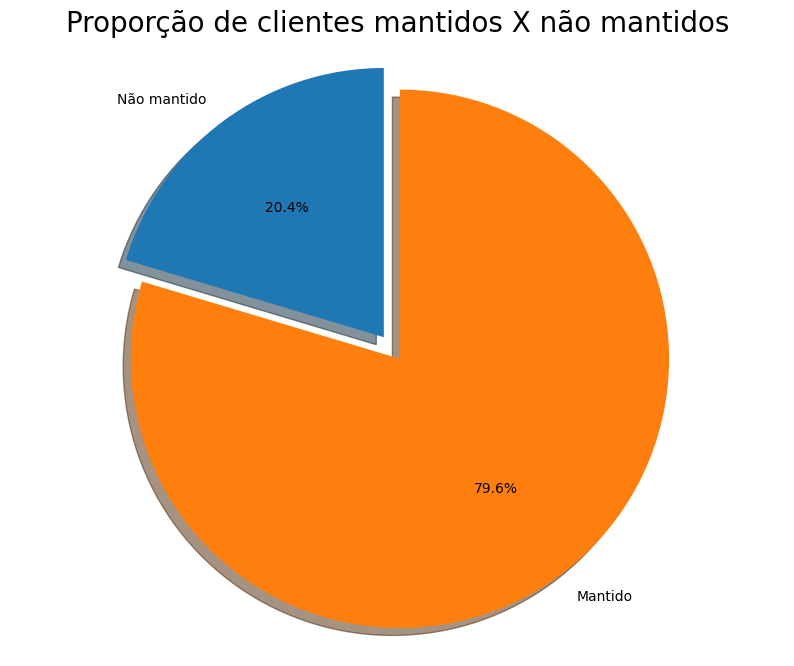

In [8]:
labels = 'Não mantido', 'Mantido'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporção de clientes mantidos X não mantidos", size = 20)
plt.show()

#### Análise da relação:
Cerca de 20% dos clientes saíram. Portanto, o modelo de referência deverá prever que 20% dos clientes irão sair. Como 20% é um número pequeno, é necessário garantir que o modelo escolhido preveja com grande precisão esses 20%, pois é do interesse do banco identificar e reter esse grupo, em vez de prever com precisão os clientes que são retidos.

<Axes: xlabel='IsActiveMember', ylabel='count'>

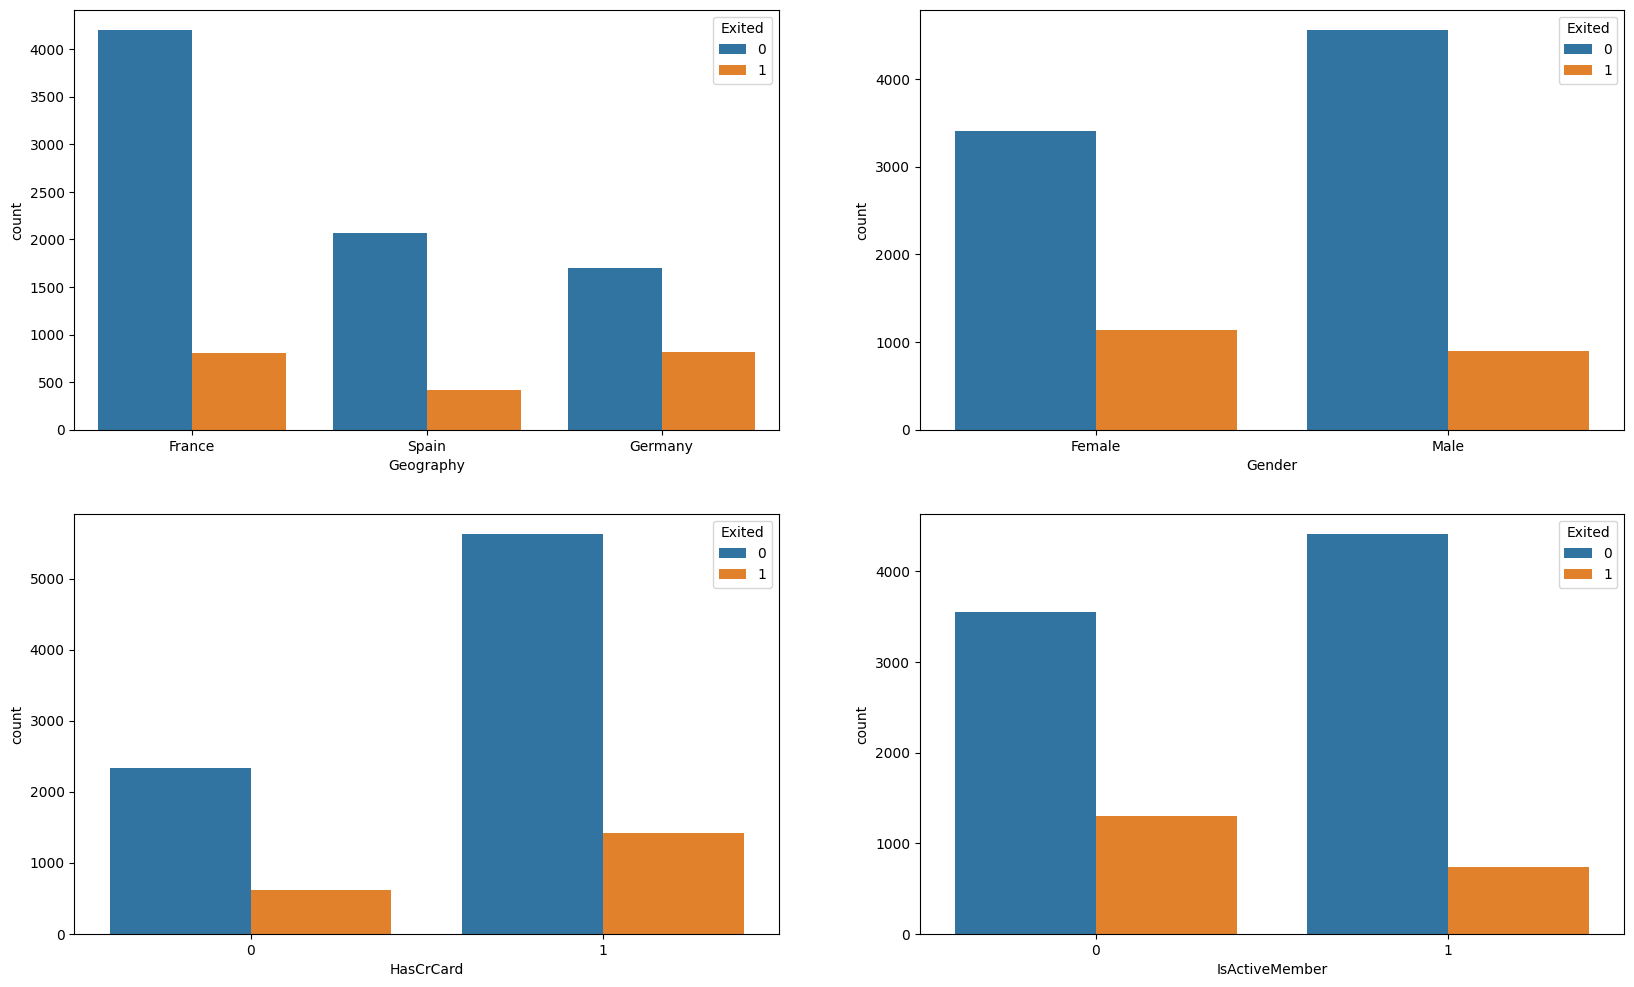

In [9]:
# Revisão da relação entre a variável de interesse e as variáveis categóricas, que atribuiem categorias.
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

#### Análise das relações entre 'status' e as variáveis categóricas:
- A maioria dos dados é de pessoas da França. No entanto, a proporção de clientes que saíram é inversamente relacionada à população de clientes, o que sugere que o banco possa ter um problema (possivelmente falta de recursos de atendimento ao cliente) nas áreas onde tem menos clientes.
- A proporção de clientes do sexo feminino que saíram também é maior do que a dos clientes do sexo masculino.
- A maioria dos clientes que saíram são aqueles com cartões de crédito. Dado que a maioria dos clientes possui cartões de crédito.
- Os membros inativos têm uma taxa de saída maior. Preocupante é que a proporção geral de membros inativos é bastante alta, o que sugere que o banco pode precisar implementar um programa para converter esse grupo em clientes ativos, pois isso certamente terá um impacto positivo na retenção de clientes.

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

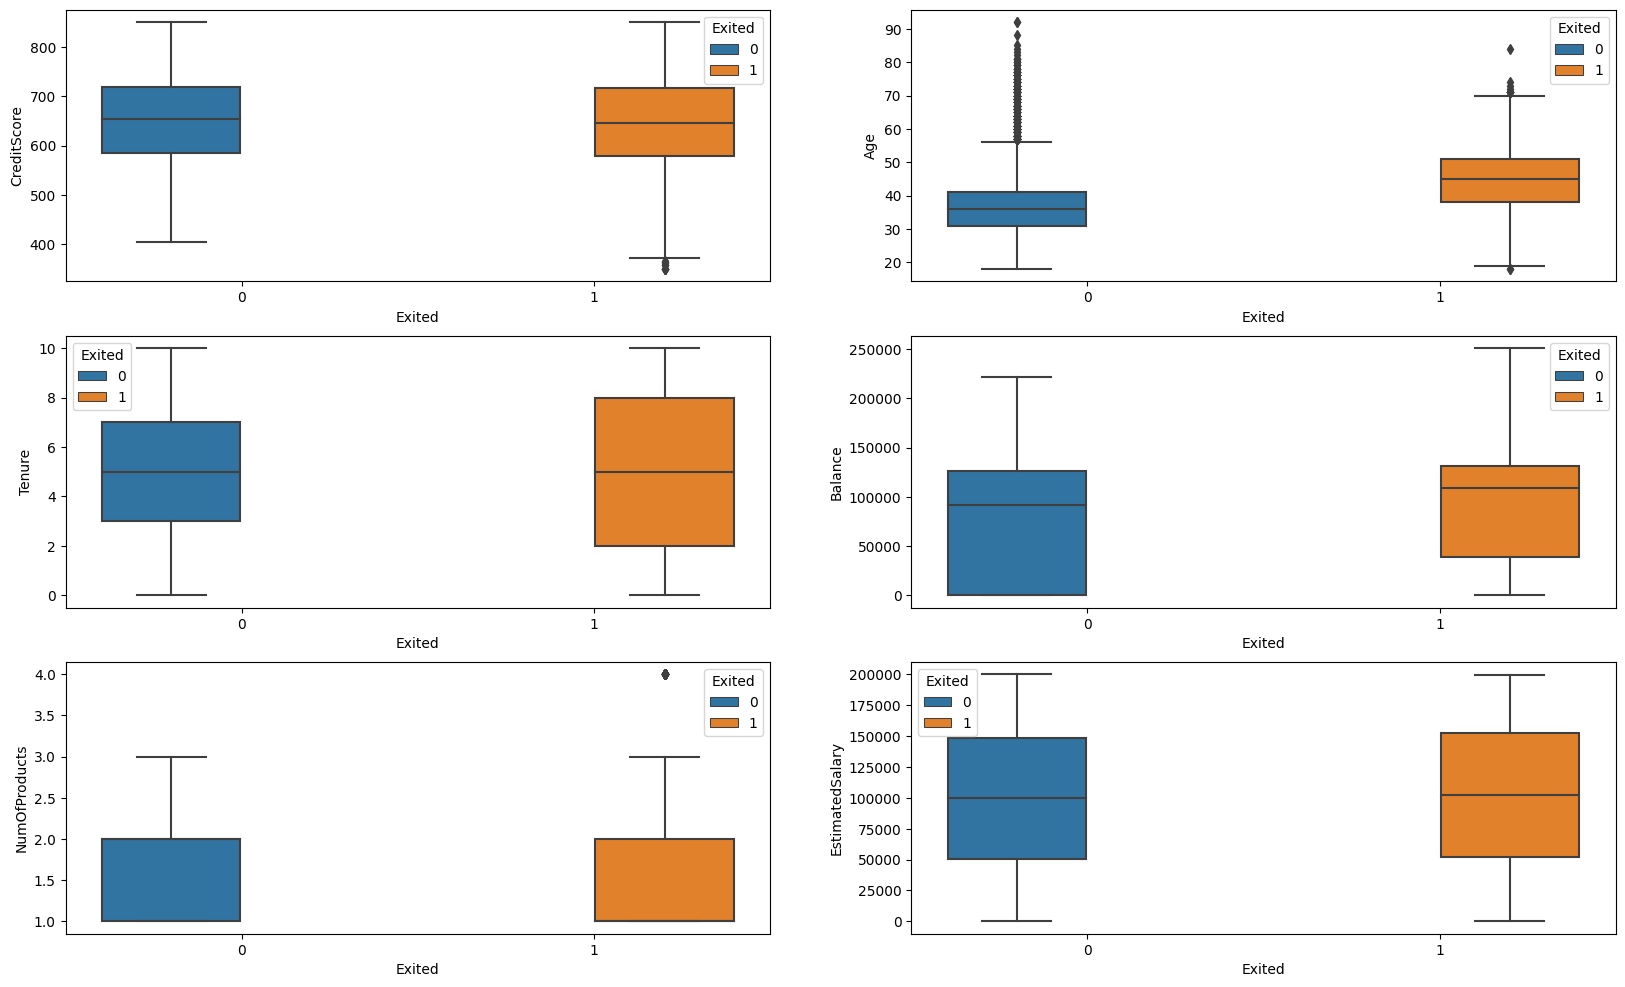

In [10]:
# Revisão da relação entre a variável de interesse e as variáveis contínuas.
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

#### Análise das relações a variável de interesse e as variáveis contínuas:
- Não há diferença significativa na distribuição do score de crédito entre os clientes mantidos e os que saíram.
- Os clientes mais velhos têm uma taxa de saída maior em comparação aos mais jovens, sugerindo que a unidade bancária revise seu mercado-alvo ou sua estratégia de retenção entre os diferentes grupos etários.
- Em relação ao tempo de permanência (tenure), os clientes nos extremos (que passaram pouco tempo ou muito tempo com o banco) têm maior probabilidade de sair em comparação com aqueles que têm um tempo médio de permanência.
- O banco está perdendo clientes com saldos significativos, o que pode afetar seu capital disponível.
- Nem o produto nem o salário têm um efeito significativo na probabilidade de saída.

### 4. Feature engineering


(-1.0, 5.0)

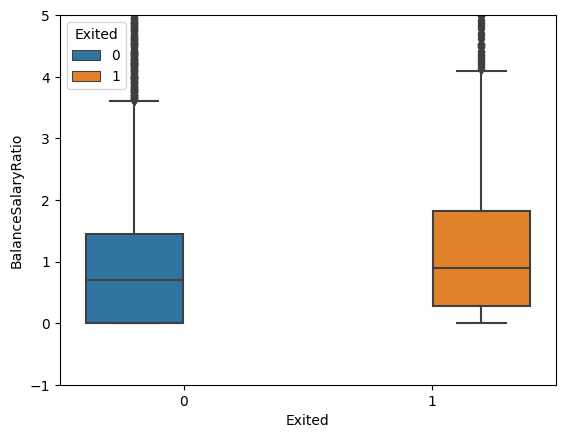

In [11]:
# Cria nova variável da relação entre saldo bancário e salário estimado
df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 5)

#### Análise da relação da taxa Saldo/Salário e a variável de interesse:
Foi observado anteriormete que o salário tem pouco efeito na probabilidade de um cliente sair. No entanto, como no gráfico acima, a taxa criada do saldo bancário em relação ao salário estimado indica que os clientes com uma proporção mais alta têm maior probabilidade de sair, o que seria preocupante para o banco, pois isso afeta sua fonte de capital.

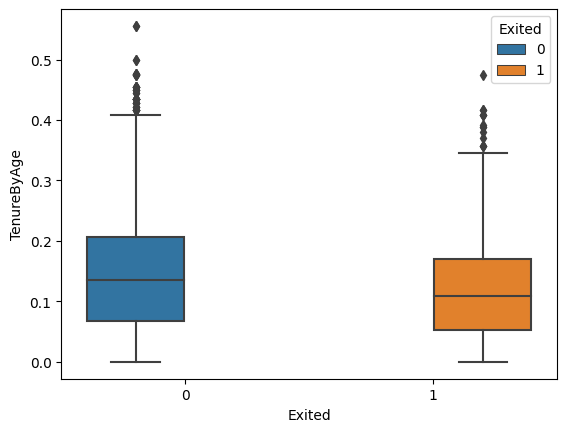

In [12]:
# Foi acrescida uma variável com o objetivo de padronizar o tempo de permanência em relação à idade:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
#plt.ylim(-1, 1)
plt.show()

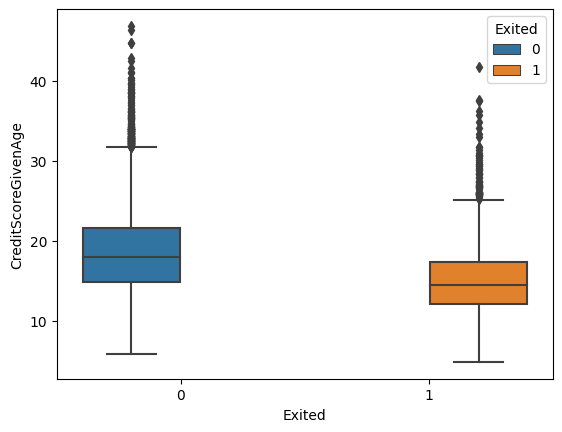

In [13]:
# A última variável inserida tem o objetivo de capturar o score de crédito em relação à idade, 
# a fim de levar em consideração o comportamento de crédito ao longo da vida adulta.
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)
sns.boxplot(y='CreditScoreGivenAge',x = 'Exited', hue = 'Exited',data = df)
# plt.ylim(-1, 1)
plt.show()

In [14]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442


### Preparando o dado para o Treinamento do Modelo

#### As seguintes operação são feitas a seguir:
- **Organização a ordem das colunas por tipo de dados**:
    1. Variável de interesse;
    2. Variáveis contínuas;
    3. Variáveis categóricas (discretas).
- **Aplicação da *codificação simétrica* para variáveis binárias**:  Para as variáveis 0 ou 1, foi alterado o valor 0 para -1, para que os modelos possam capturar uma relação negativa 
quando o atributo for inaplicável, para realizar uma simetria na influência da variável;
- **Aplicação do formato *on-hot* e *codificação simétrica*** para as demais variáveis categóricas.
- **Normalicação das variáveis contínuas usando a escala *Min/Max***

In [15]:
# Rearranjando as colunas por tipo de dado
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df = df[['Exited'] + continuous_vars + cat_vars]
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
0,1,619,42,2,0.00,1,101348.88,0.000000,0.047619,14.738095,1,1,France,Female
1,0,608,41,1,83807.86,1,112542.58,0.744677,0.024390,14.829268,0,1,Spain,Female
2,1,502,42,8,159660.80,3,113931.57,1.401375,0.190476,11.952381,1,0,France,Female
3,0,699,39,1,0.00,2,93826.63,0.000000,0.025641,17.923077,0,0,France,Female
4,0,850,43,2,125510.82,1,79084.10,1.587055,0.046512,19.767442,1,1,Spain,Female


In [16]:
# Aplicando codificação simétrica para variáveis booleanas
df.loc[df.HasCrCard == 0, 'HasCrCard'] = -1
df.loc[df.IsActiveMember == 0, 'IsActiveMember'] = -1
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
0,1,619,42,2,0.00,1,101348.88,0.000000,0.047619,14.738095,1,1,France,Female
1,0,608,41,1,83807.86,1,112542.58,0.744677,0.024390,14.829268,-1,1,Spain,Female
2,1,502,42,8,159660.80,3,113931.57,1.401375,0.190476,11.952381,1,-1,France,Female
3,0,699,39,1,0.00,2,93826.63,0.000000,0.025641,17.923077,-1,-1,France,Female
4,0,850,43,2,125510.82,1,79084.10,1.587055,0.046512,19.767442,1,1,Spain,Female


In [17]:
# usando formato "one-hot" para as demais variáveis categóricas
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df[i].dtype == str or df[i].dtype == object):
        for j in df[i].unique():
            df[i+'_'+j] = np.where(df[i] == j,1,-1)
        remove.append(i)
df = df.drop(remove, axis=1)
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,101348.88,0.000000,0.047619,14.738095,1,1,1,-1,-1,1,-1
1,0,608,41,1,83807.86,1,112542.58,0.744677,0.024390,14.829268,-1,1,-1,1,-1,1,-1
2,1,502,42,8,159660.80,3,113931.57,1.401375,0.190476,11.952381,1,-1,1,-1,-1,1,-1
3,0,699,39,1,0.00,2,93826.63,0.000000,0.025641,17.923077,-1,-1,1,-1,-1,1,-1
4,0,850,43,2,125510.82,1,79084.10,1.587055,0.046512,19.767442,1,1,-1,1,-1,1,-1


In [18]:
# Normalizando as variáveis continuas usando a escala minMax
minVec = df[continuous_vars].min().copy()
maxVec = df[continuous_vars].max().copy()
df[continuous_vars] = (df[continuous_vars]-minVec)/(maxVec-minVec)
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,0.538,0.324324,0.2,0.000000,0.000000,0.506735,0.000000,0.085714,0.235083,1,1,1,-1,-1,1,-1
1,0,0.516,0.310811,0.1,0.334031,0.000000,0.562709,0.000070,0.043902,0.237252,-1,1,-1,1,-1,1,-1
2,1,0.304,0.324324,0.8,0.636357,0.666667,0.569654,0.000132,0.342857,0.168807,1,-1,1,-1,-1,1,-1
3,0,0.698,0.283784,0.1,0.000000,0.333333,0.469120,0.000000,0.046154,0.310859,-1,-1,1,-1,-1,1,-1
4,0,1.000,0.337838,0.2,0.500246,0.000000,0.395400,0.000150,0.083721,0.354739,1,1,-1,1,-1,1,-1


#### Rebalanceando o banco de dados
Nesse passo aplicaremos o algorítmo SMOTE (Synthetic Minority Oversampling Technique) de balanceamento das amostras de treinamento.

O algoritmo SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de balanceamento de classes utilizada em problemas de aprendizado de máquina quando há desequilíbrio entre as classes do conjunto de dados. O desequilíbrio de classes ocorre quando uma classe tem um número significativamente menor de exemplos em relação a outras classes.

In [19]:
col_y = 'Exited'
X = df.loc[:, df.columns != col_y]
y = df.loc[:, df.columns == col_y]
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=[col_y])
# we can Check the numbers of our data
print("Tamanho do oversampled é: ",len(os_data_X))
print("Número de não aderência:",len(os_data_y[os_data_y[col_y]==0]))
print("Número de aderência:",len(os_data_y[os_data_y[col_y]==1]))
print("Proporção de não aderência: ",len(os_data_y[os_data_y[col_y]==0])/len(os_data_X)*100, "%")
print("Proporção de aderência:", len(os_data_y[os_data_y[col_y]==1])/len(os_data_X)*100, "%")

Tamanho do oversampled é:  11168
Número de não aderência: 5584
Número de aderência: 5584
Proporção de não aderência:  50.0 %
Proporção de aderência: 50.0 %


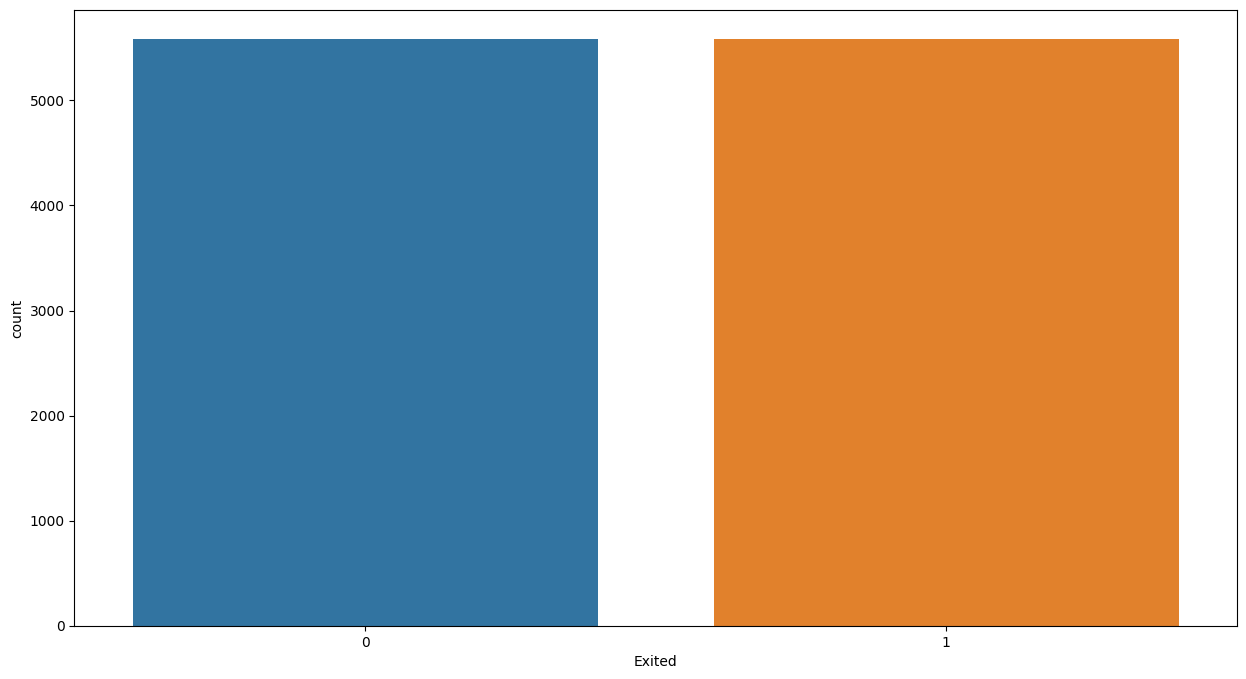

In [20]:
plt.figure(figsize=(15,8))
figure = sns.countplot(x=col_y, data = os_data_y)

In [21]:
# Separa cojunto de amostra de treinamento
X=os_data_X.loc[:, os_data_X.columns != col_y]
y=os_data_y[col_y]

### Ajuste e seleção de modelo
Para realização previsão da evasão de clientes em unidades bancárias, além de modelos de regressão logística, optou-se em
realizar comparações de performance com outros tipos de algorítmos classificadores

Os seguintes modelos de aprendisado serão experimentados e ajustados para treinamento e posterior avaliação:

- Regressão logística no espaço primal e com diferentes kernels
- SVM (Support Vector Machine) no espaço primal e com diferentes kernels
- Classificadores Random Forest e Extreme Gradient Boosting

In [22]:
# Funções de apoio  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Modelos de Ajuste
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Funções de Pontuação
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#### Ajustos do hiperparâmetros cálculo dos melhores scores para avaliação dos modelos
O código que vem a seguir é responsável em realizar a busca em grid (*Grid Search*) com validação cruzada (*Cross-Validation*) para encontrar os melhores parâmetros de treinamento para os modelos de predição escolhidos para avaliação das variáveis do problema.

Além disso calcula o melhor score de cada modelo.

O objetivo é ajustar os modelos aos dados de treinamento e encontrar a melhor configuração de parâmetros que maximize o desempenho dos modelos na previsão da variável de destino `Exited`.

In [23]:
# Funções para recuperar o melhor score do modelo Avaliado
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [24]:
# Regressão logística primal - 
if not _debug:
    param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
                  'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
    log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)
    log_primal_Grid.fit(X,y)
    best_model(log_primal_Grid)

0.7097069403131147
{'C': 0.5, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=0.5, max_iter=250, tol=1e-05)


In [25]:
# Rregressão logística com kernel polinomial de grau 2.
if not _debug:
    param_grid = {'C': [0.1,10,50], 'max_iter': [300,500], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'],
                  'tol':[0.0001,0.000001]}
    poly2 = PolynomialFeatures(degree=2)
    df_train_pol2 = poly2.fit_transform(X)
    log_pol2_Grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5, refit=True, verbose=0)
    log_pol2_Grid.fit(df_train_pol2,y)
    best_model(log_pol2_Grid)

0.7930693700458773
{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
LogisticRegression(C=50, max_iter=300, solver='liblinear')


In [26]:
# SVM Com RBF Kernel
if not _debug:
    param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}
    SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
    SVM_grid.fit(X,y)
    best_model(SVM_grid)

0.7971883921630208
{'C': 150, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=150, gamma=0.1, probability=True)


In [27]:
# SVM com kernel polinomial
if not _debug:
    param_grid = {'C': [0.5,1,10,50,100], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['poly'],'degree':[2,3] }
    SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
    SVM_grid.fit(X,y)
    best_model(SVM_grid)

0.7820557581726769
{'C': 100, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
SVC(C=100, gamma=0.1, kernel='poly', probability=True)


In [28]:
# Classificador Random Forest
if not _debug:
    param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
    RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
    RanFor_grid.fit(X,y)
    best_model(RanFor_grid)

0.8421421014079922
{'max_depth': 8, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 50}
RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=5,
                       n_estimators=50)


In [29]:
# classificador Extreme Gradient Boosting
if not _debug:
    param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
    xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
    xgb_grid.fit(X,y)
    best_model(xgb_grid)

0.8938136385887443
{'gamma': 0.001, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


#### Treinando os modelos
Após econtrar os melhores parâmetros de treinamento para os modelos de predição escolhidos, os modelos são gerados com os melhores parâmetros apurados para posterior avaliação

In [30]:
# Fit primal logistic regression  usando melhoeres parâmetros encontrados
# {'C': 0.5, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
log_primal = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='auto',n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(X,y)

LogisticRegression(C=0.5, max_iter=250, tol=1e-05)

In [31]:
# Fit logistic regression with pol 2 kernel  usando melhoeres parâmetros encontrados
# {'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(X)
log_pol2 = LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, multi_class='auto', n_jobs=None, 
                              penalty='l2', random_state=None, solver='liblinear',tol=0.0001, verbose=0, warm_start=False)
log_pol2.fit(df_train_pol2,y)

LogisticRegression(C=50, max_iter=300, solver='liblinear')

In [32]:
# Fit SVM with RBF Kernel  usando melhoeres parâmetros encontrados
# {'C': 150, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVM_RBF = SVC(C=150, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', 
              degree=3, gamma=0.1, kernel='rbf', max_iter=-1, probability=True, 
              random_state=None, shrinking=True,tol=0.001, verbose=False)
SVM_RBF.fit(X,y)

SVC(C=150, gamma=0.1, probability=True)

In [33]:
# Fit SVM with Pol Kernel usando melhoeres parâmetros encontrados
# {'C': 100, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
SVM_POL = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',  max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)
SVM_POL.fit(X,y)

SVC(C=100, degree=2, gamma=0.1, kernel='poly', probability=True)

In [34]:
# Fit Random Forest classifier usando melhoeres parâmetros encontrados
# {'max_depth': 8, 'max_features': 8, 'min_samples_split': 7, 'n_estimators': 100}
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=8, max_features=8, max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_samples_leaf=1, min_samples_split=7,min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(X,y)

RandomForestClassifier(max_depth=8, max_features=8, min_samples_split=7)

In [50]:
# Fit Extreme Gradient Boost Classifier usando melhoeres parâmetros encontrados
# {'gamma': 0.001, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100}
XGB = XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,colsample_bytree=None, gamma=0.001, learning_rate=0.2, max_delta_step=0,max_depth=8,
                    min_child_weight=1, missing=1, n_estimators=100,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, verbosity=0, subsample=1)
XGB.fit(X,y)

#### Revisão da acurácia do melhor modelo: Há um interesse especial no desempenho na previsão dos casos positivos (clientes que cancelam).

In [36]:
# Regressão logística primal
print(classification_report(y, log_primal.predict(X)))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      5584
           1       0.71      0.72      0.71      5584

    accuracy                           0.71     11168
   macro avg       0.71      0.71      0.71     11168
weighted avg       0.71      0.71      0.71     11168



In [37]:
# Regreção Logistica with degree 2 polynomial kernel
print(classification_report(y,  log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      5584
           1       0.81      0.79      0.80      5584

    accuracy                           0.80     11168
   macro avg       0.80      0.80      0.80     11168
weighted avg       0.80      0.80      0.80     11168



In [38]:
# SVM Com Kernel RBF
print(classification_report(y,  SVM_RBF.predict(X)))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      5584
           1       0.82      0.84      0.83      5584

    accuracy                           0.83     11168
   macro avg       0.83      0.83      0.83     11168
weighted avg       0.83      0.83      0.83     11168



In [39]:
# SVM com kernel polinomial
print(classification_report(y,  SVM_POL.predict(X)))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      5584
           1       0.79      0.76      0.77      5584

    accuracy                           0.78     11168
   macro avg       0.78      0.78      0.78     11168
weighted avg       0.78      0.78      0.78     11168



In [40]:
# Classificador Random Forest
print(classification_report(y,  RF.predict(X)))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5584
           1       0.87      0.86      0.87      5584

    accuracy                           0.87     11168
   macro avg       0.87      0.87      0.87     11168
weighted avg       0.87      0.87      0.87     11168



In [41]:
# Classificador Extreme Gradient Boost 
print(classification_report(y,  XGB.predict(X)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5584
           1       0.99      0.99      0.99      5584

    accuracy                           0.99     11168
   macro avg       0.99      0.99      0.99     11168
weighted avg       0.99      0.99      0.99     11168



#### Analisando os resultados encontrados
Com base nos resultados acima, o objetivo principal era prever os clientes que possivelmente cancelariam seus serviços, para que possam ser incluídos em algum tipo de programa para prevenir seu desligameto da unidade bancária. Portanto, as **métricas recall** para os casos identificados como 1 são mais importantes que as **métricas precision**  do modelo, neste caso.

Considerando que nos dados tem-se apenas 20% de desligamentos, uma **métrica recall** maior do que esse valor já será uma melhoria significativa. Entretanto, quere-se alcançar o maior taxa possível de acertos, ao mesmo tempo em que se mantém uma alta **métrica precision**, para que a unidade bancária possa concentrar seus esfoços no relacionamento dos clientes destacados pelo o melhor modelo treinado, sem desperdiçar seus esforços com falsos positivos.

Isto posto, dada a análise dos modelos ajustados acima, os melhores modelos que ofereceram um equilíbrio adequado entre as **métricas recall e precision** são o *Random Forest - RF* e o *Extreme Gradient Boost - XGB*, com uma vantagem significativa para  *XGB*, onde obteve 0,99 na métrica f1-score para o valor 0 e 1 nas amostras de treino.

Antes chegar em uma conclusão a respeito do modelo que melhor atende as necessidades do problema, deve-se avaliar o desempenho dos dois modelos com as amostras de teste. 

#### Analisando a Curva ROC dos Modelos

In [42]:
X_pol2 = df_train_pol2
auc_log_primal, fpr_log_primal, tpr_log_primal = get_auc_scores(y, log_primal.predict(X),log_primal.predict_proba(X)[:,1])
auc_log_pol2, fpr_log_pol2, tpr_log_pol2 = get_auc_scores(y, log_pol2.predict(X_pol2),log_pol2.predict_proba(X_pol2)[:,1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X),SVM_RBF.predict_proba(X)[:,1])
auc_SVM_POL, fpr_SVM_POL, tpr_SVM_POL = get_auc_scores(y, SVM_POL.predict(X),SVM_POL.predict_proba(X)[:,1])
auc_RF, fpr_RF, tpr_RF = get_auc_scores(y, RF.predict(X),RF.predict_proba(X)[:,1])
auc_XGB, fpr_XGB, tpr_XGB = get_auc_scores(y, XGB.predict(X),XGB.predict_proba(X)[:,1])

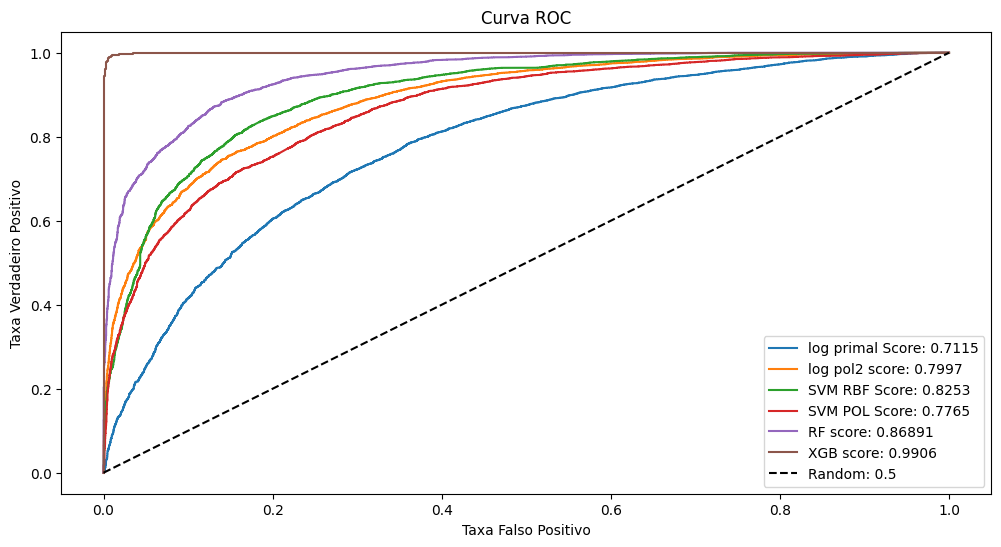

In [43]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log_primal, tpr_log_primal, label = 'log primal Score: ' + str(round(auc_log_primal, 5)))
plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

#### Análise do Gráfico:
A curva ROC (Receiver Operating Characteristic) é uma representação gráfica do desempenho de um modelo de classificação binária. Ela ilustra a relação entre a taxa de verdadeiro positivo (sensibilidade) e a taxa de falso positivo (especificidade) para diferentes limiares de classificação.

A análise da curva ROC é útil para avaliar a capacidade discriminativa do modelo em distinguir entre as classes positiva e negativa. Quanto mais próxima a curva estiver do canto superior esquerdo do gráfico, melhor será o desempenho do modelo. Um modelo ideal teria uma curva ROC que passasse pelo ponto (0,1), indicando uma taxa de verdadeiro positivo de 100% e uma taxa de falso positivo de 0%.

Uma métrica comumente usada para avaliar a qualidade da curva ROC é a AUC (Area Under the Curve), que representa a área sob a curva ROC. Quanto maior a AUC, melhor o desempenho do modelo. Um valor de AUC igual a 0,5 indica um modelo que é equivalente a um classificador aleatório, enquanto um valor de AUC igual a 1 representa um modelo perfeito.

No gráfico acima, apresenta-se a curva ROC dos diferentes modelos foram avaliados. Os rótulos das curvas incluem a pontuação (AUC) de cada modelo. Comparando as curvas e os valores de AUC, é possível ter uma ideia da eficácia relativa de cada modelo. Modelos com maiores valores de AUC tendem a ter um desempenho melhor na classificação.

Para os modelos RF e XGB a pontuação AUC foi bem alta, chegando perto de 1 para o XGB, considerando apenas os dados de treinamento.

#### Testando a precisão do Modelo com o data frame de teste
O procedimento de balanceamento usando o algorítmo  deve ser aplicado apenas no conjunto de treinamento. A ideia é corrigir o desbalanceamento da variável de interesse ('Exited') para que o modelo de regressão logística possa aprender adequadamente os padrões dos dados. No entanto, o conjunto de teste deve permanecer o mais próximo possível da distribuição original dos dados, a fim de avaliar a capacidade de generalização do modelo.

Aqui serão testados dos dois modelos que apresentaram melhor desempenho

In [45]:
y_t = y_test.Exited
X_t = X_test.loc[:, X_test.columns != col_y]


In [46]:
print(classification_report( y_t,  RF.predict(X_t)))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2379
           1       0.54      0.71      0.61       621

    accuracy                           0.81      3000
   macro avg       0.73      0.77      0.74      3000
weighted avg       0.84      0.81      0.82      3000



In [47]:
print( classification_report( y_t,  XGB.predict(X_t)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2379
           1       0.66      0.58      0.62       621

    accuracy                           0.85      3000
   macro avg       0.78      0.75      0.76      3000
weighted avg       0.84      0.85      0.85      3000



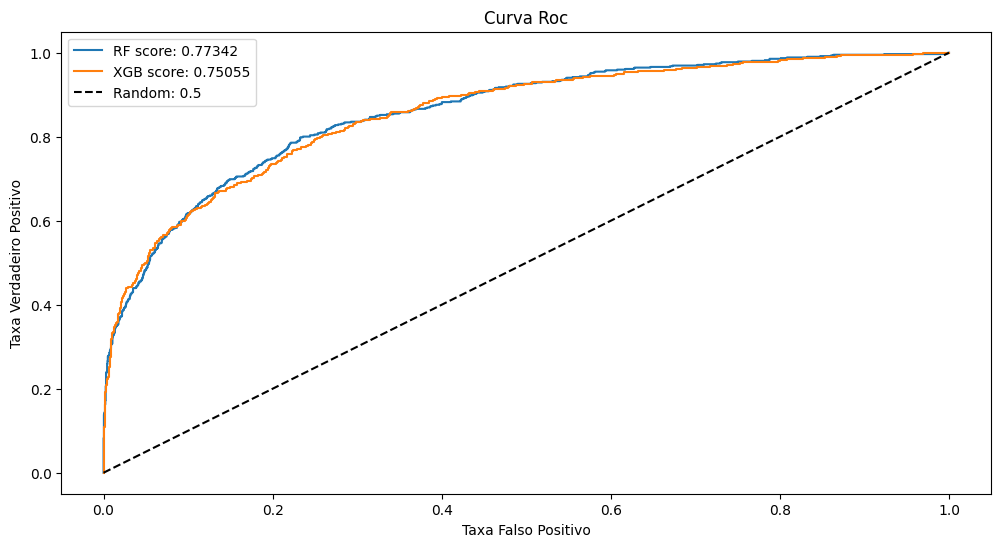

In [48]:
auc_RF_test, fpr_RF_test, tpr_RF_test    = get_auc_scores(y_t, RF.predict(X_t),
                                                          RF.predict_proba(X_t)[:,1])
auc_XGB_test, fpr_XGB_test, tpr_XGB_test = get_auc_scores(y_t, XGB.predict(X_t),
                                                          XGB.predict_proba(X_t)[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot(fpr_XGB_test, tpr_XGB_test, label = 'XGB score: ' + str(round(auc_XGB_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Verdadeiro Positivo')
plt.title('Curva Roc')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

#### RF score ``versus`` XGB score
Os dois algorítmos, tanto RF quanto XGB tiveram uma queda significativa de acurárcia para casos indentificados com 1 para abandono após a aferição da massa de teste, apesar de terem mantido a acurácia de acerto do 0 (permanência).

Apesar de terem uma taxa AUC (Area Under the Curve) da curva ROC bem semelhantes, o modelo de dados que teve melhor acurácia na taxa ``recall`` para acertos de 1 foi o Ramdom Forest. Como avaliado ateriormente, as **métricas recall** para os casos identificados como 1 são mais importantes que as **métricas precision**,  no caso em questão.

Como demonstrado e pelos resultados apresentados, entende-se que o modelo a ser usado na predição da abonos de clientes deve ser o **Classificador Extreme Gradient Boost**

### Questão b) Encontre as features mais importantes para reteção dos cliente, interprete os resultados.

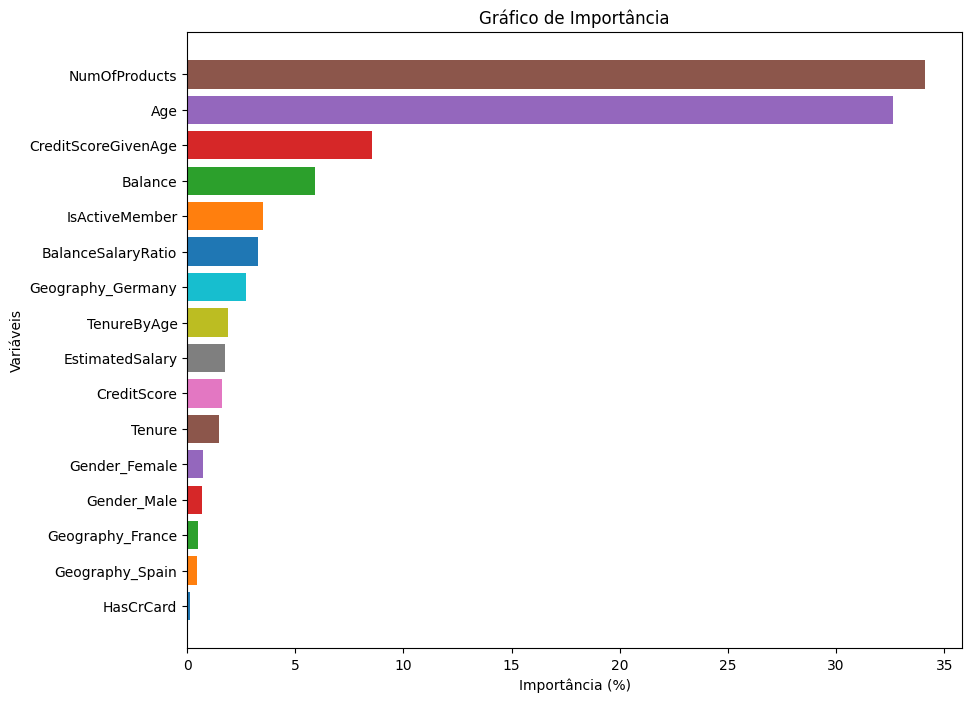

In [62]:

odds = (RF.feature_importances_) * 100
coefficients  = pd.DataFrame(odds, X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=True)
plt.figure(figsize=(10,8))
plt.barh(coefficients.index, coefficients['coef'], color=['C{}'.format(i) for i in range(len(coefficients))])
plt.xlabel('Importância (%)')
plt.ylabel('Variáveis')
plt.title('Gráfico de Importância')
plt.show()

#### Análise do Gráfico
Com o modelo escolhido, pelo gráfico acima, as features mais importantes para reteção dos cliente são `Número de Produtos` e `idade`. A importância das duas somadas supera 70% em relação às outras.

A terceira variável, `Pontuação de Crédito Dada a Idade` exerce uma importância proporcionalemte, de cerca de 10%, possivelmente influenciada pela variável `idade`.

Conforme demonstrado acima, a grande maioria dos clientes tem entre 1 e 2 número de produtos. Se a unidade bancaria incentivar os clientes a adquirirem mas produtos, poderia gerar um maior compromisso do cliente e fraria com que ele permanece mais tempo como ligado ao banco.

Foi demonstrado acima que há uma evasão maior de clientes entre 40 e 50 anos. Então sugere-se que faça-se uma campanha focada nessa faixa etária para promover a fidelidade de clientes dessa faixa hetária.

### Questão c) Explique o motivo do uso da regressão logística e não da regressão linear.
O Problema apresentado é tipicamente de classificação binária, onde se tenta prever os motivos que levam as pessoas a se desligarem de uma instituição bancária.

Essa talvez seja a principal caracteristica para aplicação de um modelo de classificação usando-se regressão linear.

No problema em questão, o Classificador Random Forest obteve um melhor desempenho que os modelos de regressão logística avaliados.